# 📊 Comprehensive Analysis: Unemployment vs Crime Rate
This notebook analyzes how unemployment rates influence crime rates across U.S. states using visualizations, statistical tests, and regression.

## 📥 1. Import Libraries and Load Dataset

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.weightstats import ztest
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# Load data
from google.colab import files
upload1 = files.upload()
df = pd.read_csv("crimebystatecombinedwithunemployment.csv")

Saving crimebystatecombinedwithunemployment.csv to crimebystatecombinedwithunemployment (1).csv


In [79]:
df.isnull().sum()

,0
state,0
unemployment,0
year,0
Population,0
violent total,0
Murder,0
rape,0
Robbery,0
Aggravated assault,0
property total,0


## 🧹 2. Prepare and Clean Data

In [80]:
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

df['total_crime'] = (df['violent_total'] + df['property_total'])

df.dropna(inplace=True)

df.head(10)

,state,unemployment,year,population,violent_total,murder,rape,robbery,aggravated_assault,property_total,burglary,larceny_theft,vehicle_theft,total_crime
0,AL,6.808,1976,3665000,388.8,15.1,21.7,96.0,256.0,3419.5,1170.0,1987.2,262.3,3808.3
1,AL,7.325,1977,3690000,414.4,14.2,25.2,96.8,278.3,3298.2,1135.5,1881.9,280.7,3712.6
2,AL,6.380,1978,3742000,419.1,13.3,25.5,99.1,281.2,3519.7,1229.3,1987.9,302.5,3938.8
3,AL,7.158,1979,3769000,413.3,13.2,27.5,109.5,263.1,3830.5,1287.3,2223.2,320.1,4243.8
4,AL,8.867,1980,3861466,448.5,13.2,30.0,132.1,273.2,4485.1,1526.7,2642.2,316.2,4933.6
5,AL,10.542,1981,3916000,470.5,11.9,26.1,126.5,306.1,4428.3,1450.7,2693.3,284.2,4898.8
6,AL,14.100,1982,3943000,447.7,10.6,26.0,112.0,299.1,4185.8,1256.2,2656.4,273.3,4633.5
7,AL,13.808,1983,3959000,416.0,9.2,23.5,98.4,284.9,3685.0,1073.1,2381.4,230.5,4101.0
8,AL,11.008,1984,3990000,431.2,9.4,25.1,96.1,300.6,3470.9,1001.8,2235.5,233.6,3902.1
9,AL,9.167,1985,4021000,457.5,9.8,26.8,105.4,315.5,3484.6,1034.9,2191.2,258.5,3942.1


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               1989 non-null   object 
 1   unemployment        1989 non-null   float64
 2   year                1989 non-null   int64  
 3   population          1989 non-null   int64  
 4   violent_total       1989 non-null   float64
 5   murder              1989 non-null   float64
 6   rape                1989 non-null   float64
 7   robbery             1989 non-null   float64
 8   aggravated_assault  1989 non-null   float64
 9   property_total      1989 non-null   float64
 10  burglary            1989 non-null   float64
 11  larceny_theft       1989 non-null   float64
 12  vehicle_theft       1989 non-null   float64
 13  total_crime         1989 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 217.7+ KB


## 🤝 3. Load, Process, and Filter by Low Poverty Rates and Medium Population

In [83]:
# Sort and classify states by population
df_sorted = df.sort_values(by='population')
low_states = df_sorted.head(3)['state'].tolist()
high_states = df_sorted.tail(3)['state'].tolist()

def classify_population_group(row):
    if row['state'] in low_states:
        return 'Low'
    elif row['state'] in high_states:
        return 'High'
    else:
        return 'Medium'

df['population_group'] = df.apply(classify_population_group, axis=1)

df_medium = df[df['population_group'] == 'Medium'].copy()
df_medium.head(10)

,state,unemployment,year,population,violent_total,murder,rape,robbery,aggravated_assault,property_total,burglary,larceny_theft,vehicle_theft,total_crime,population_group
0,AL,6.808,1976,3665000,388.8,15.1,21.7,96.0,256.0,3419.5,1170.0,1987.2,262.3,3808.3,Medium
1,AL,7.325,1977,3690000,414.4,14.2,25.2,96.8,278.3,3298.2,1135.5,1881.9,280.7,3712.6,Medium
2,AL,6.380,1978,3742000,419.1,13.3,25.5,99.1,281.2,3519.7,1229.3,1987.9,302.5,3938.8,Medium
3,AL,7.158,1979,3769000,413.3,13.2,27.5,109.5,263.1,3830.5,1287.3,2223.2,320.1,4243.8,Medium
4,AL,8.867,1980,3861466,448.5,13.2,30.0,132.1,273.2,4485.1,1526.7,2642.2,316.2,4933.6,Medium
5,AL,10.542,1981,3916000,470.5,11.9,26.1,126.5,306.1,4428.3,1450.7,2693.3,284.2,4898.8,Medium
6,AL,14.100,1982,3943000,447.7,10.6,26.0,112.0,299.1,4185.8,1256.2,2656.4,273.3,4633.5,Medium
7,AL,13.808,1983,3959000,416.0,9.2,23.5,98.4,284.9,3685.0,1073.1,2381.4,230.5,4101.0,Medium
8,AL,11.008,1984,3990000,431.2,9.4,25.1,96.1,300.6,3470.9,1001.8,2235.5,233.6,3902.1,Medium
9,AL,9.167,1985,4021000,457.5,9.8,26.8,105.4,315.5,3484.6,1034.9,2191.2,258.5,3942.1,Medium


In [84]:
# Step 2: Upload and load the poverty dataset
upload = files.upload()

poverty_df = pd.read_csv("hstpov9.csv", header=[4, 5, 6], skiprows=[7])

poverty_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in poverty_df.columns]

percent_cols = [col for col in poverty_df.columns if 'Percent' in col]
poverty_df = poverty_df[['Unnamed: 0_level_0_Unnamed: 0_level_1_2023', percent_cols[0]]]

poverty_df.columns = ['year', 'poverty_rate']

poverty_df['year'] = pd.to_numeric(poverty_df['year'].str.extract('(\d{4})')[0], errors='coerce')
poverty_df['poverty_rate'] = pd.to_numeric(poverty_df['poverty_rate'], errors='coerce')

poverty_df = poverty_df[poverty_df['year'].between(1976, 2014)].dropna()

if 'poverty_rate' in df.columns:
    df_medium = df_medium.drop(columns=['poverty_rate'])

df_medium = df_medium[df_medium['year'].between(1976, 2014)]

df_medium = pd.merge(df_medium, poverty_df, on='year', how='left')

median_poverty = poverty_df['poverty_rate'].median()
print(f"Median poverty rate (1976–2014): {median_poverty}")

df_filtered = df_medium[df_medium['poverty_rate'].notna() & (df_medium['poverty_rate'] <= median_poverty)]

print("\nFiltered Crime Data (Poverty Rate < Median, 1976–2014):")
print(df_filtered[['state', 'year', 'violent_total', 'property_total', 'poverty_rate']].head(30))


Saving hstpov9.csv to hstpov9 (11).csv
Median poverty rate (1976–2014): 13.45

Filtered Crime Data (Poverty Rate < Median, 1976–2014):
   state  year  violent_total  property_total  poverty_rate
0     AL  1976          388.8          3419.5          11.8
1     AL  1977          414.4          3298.2          11.6
2     AL  1978          419.1          3519.7          11.4
3     AL  1979          413.3          3830.5          11.7
4     AL  1980          448.5          4485.1          13.0
11    AL  1987          559.2          3892.2          13.4
12    AL  1988          558.6          4003.1          13.0
13    AL  1989          590.8          4037.0          12.8
21    AL  1997          564.5          4325.3          13.3
22    AL  1998          512.1          4085.0          12.7
23    AL  1999          490.2          3922.3          11.9
24    AL  2000          486.2          4059.7          11.3
25    AL  2001          438.2          3876.8          11.7
26    AL  2002          4

In [85]:
df_filtered.isnull().sum()

,0
state,0
unemployment,0
year,0
population,0
violent_total,0
murder,0
rape,0
robbery,0
aggravated_assault,0
property_total,0


## 📊 4. Descriptive Statistics

In [86]:
print("\nDescriptive Statistics before filtering cofounding variables:\n", df[['unemployment', 'violent_total', 'property_total','total_crime']].describe())
print("\nDescriptive Statistics after filtering cofounding variables:\n", df_filtered[['unemployment', 'violent_total', 'property_total','total_crime']].describe())

# Outlier detection with z-scores
df_filtered['unemployment_z'] = stats.zscore(df_filtered['unemployment'])
df_filtered['violent_z'] = stats.zscore(df_filtered['violent_total'])
df_filtered['property_z'] = stats.zscore(df_filtered['property_total'])
df_filtered['crime_rate_z'] = stats.zscore(df_filtered['total_crime'])

# Outliers
print("\nUnemployment Outliers (|z| > 3):", df_filtered[np.abs(df_filtered['unemployment_z']) > 3].shape[0])
print("Violent Crime Outliers (|z| > 3):", df_filtered[np.abs(df_filtered['violent_z']) > 3].shape[0])
print("Property Crime Outliers (|z| > 3):", df_filtered[np.abs(df_filtered['property_z']) > 3].shape[0])
print("Crime Rate Outliers (|z| > 3):", df_filtered[np.abs(df_filtered['crime_rate_z']) > 3].shape[0])## Remove Outliers and Keep Variable Name

# Remove outliers
z_score_threshold = 3

print("\n")

print(f"Shape of df_filtered before outlier removal: {df_filtered.shape}")

df_filtered = df_filtered[
    (np.abs(df_filtered['unemployment_z']) <= z_score_threshold) &
    (np.abs(df_filtered['violent_z']) <= z_score_threshold) &
    (np.abs(df_filtered['property_z']) <= z_score_threshold) &
    (np.abs(df_filtered['crime_rate_z']) <= z_score_threshold)
].copy()

print(f"Shape of df_filtered after outlier removal: {df_filtered.shape}")

print("\nDescriptive Statistics after removing outliers:\n", df_filtered[['unemployment', 'violent_total', 'property_total','total_crime']].describe())



Descriptive Statistics before filtering cofounding variables:
        unemployment  violent_total  property_total   total_crime
count   1989.000000    1989.000000     1989.000000   1989.000000
mean       6.127662     464.795676     4014.478331   4479.274007
std        2.080686     295.760230     1270.984536   1475.144482
min        2.300000      47.000000     1524.400000   1623.700000
25%        4.617000     275.500000     3043.100000   3388.000000
50%        5.800000     412.300000     3919.500000   4320.200000
75%        7.325000     590.000000     4758.200000   5350.500000
max       17.825000    2921.800000     9512.100000  12173.500000

Descriptive Statistics after filtering cofounding variables:
        unemployment  violent_total  property_total   total_crime
count    960.000000     960.000000      960.000000    960.000000
mean       5.226946     445.328125     4002.212708   4447.540833
std        1.549899     266.355218     1215.371208   1387.723084
min        2.300000      54.

<ipython-input-86-ed7821c94f3f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['unemployment_z'] = stats.zscore(df_filtered['unemployment'])
<ipython-input-86-ed7821c94f3f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['violent_z'] = stats.zscore(df_filtered['violent_total'])
<ipython-input-86-ed7821c94f3f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

## 📈 5. Visualizations

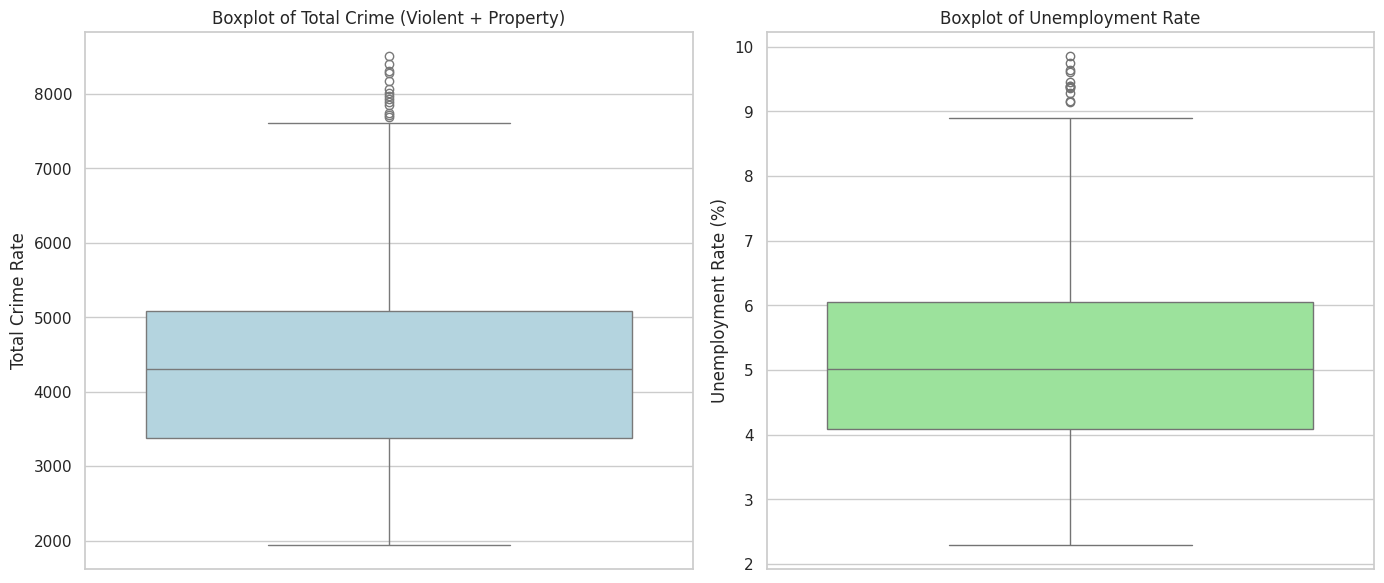

In [99]:
# 🔹 1.Boxplot
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(y=df_filtered['total_crime'], ax=axes[0], color='lightblue')
axes[0].set_title('Boxplot of Total Crime (Violent + Property)')
axes[0].set_ylabel('Total Crime Rate')

sns.boxplot(y=df_filtered['unemployment'], ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Unemployment Rate')
axes[1].set_ylabel('Unemployment Rate (%)')

plt.tight_layout()
plt.show()

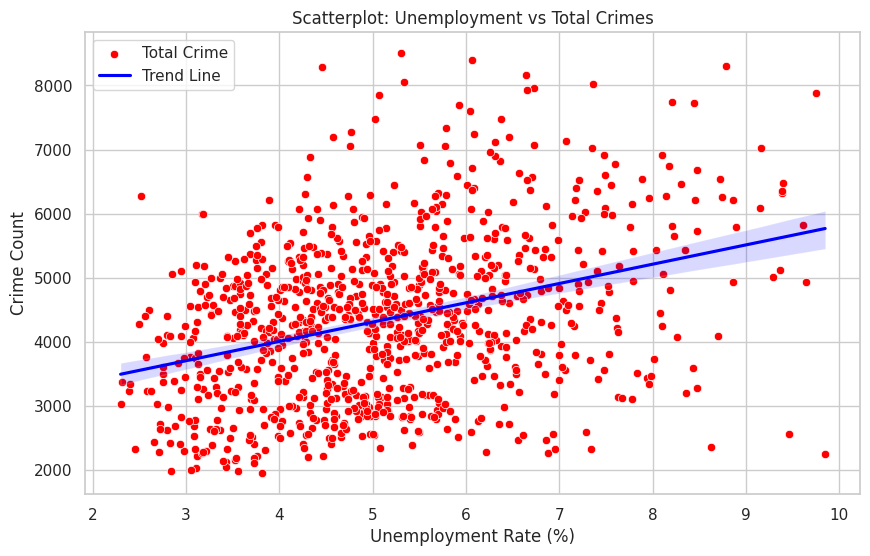

In [88]:
# 🔹 2. scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='unemployment', y='total_crime', label='Total Crime', color='red')
sns.regplot(data=df_filtered, x='unemployment', y='total_crime', scatter=False, color='blue', label='Trend Line')
plt.title('Scatterplot: Unemployment vs Total Crimes')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

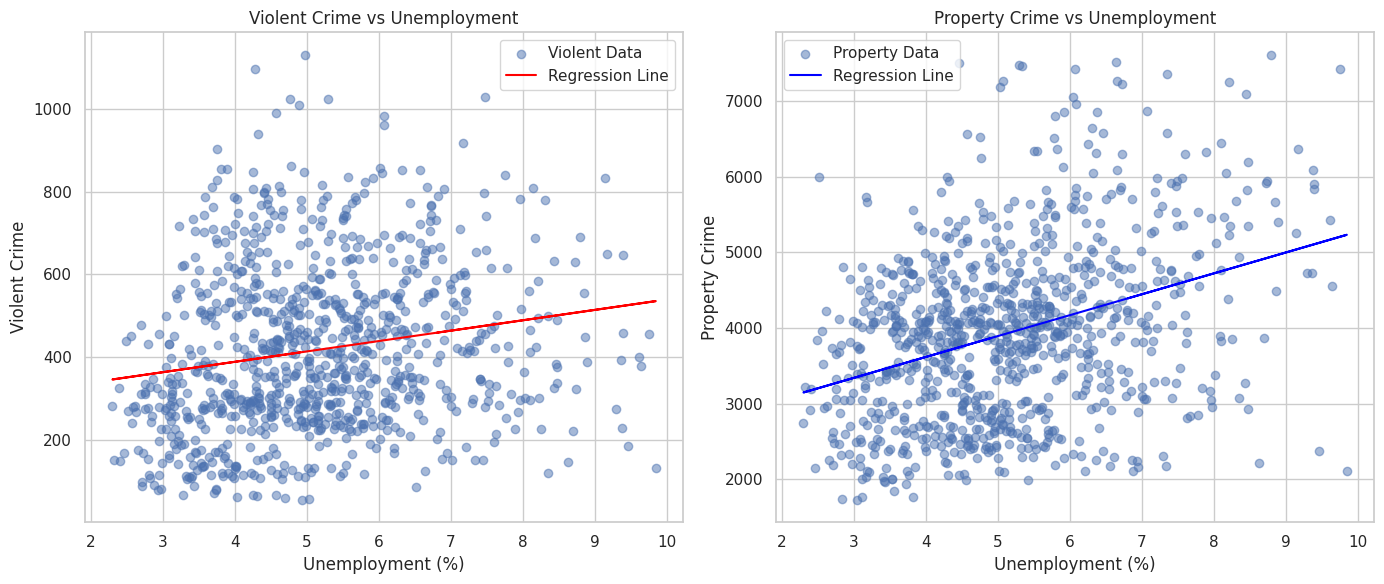

In [89]:
# 🔹 3. Simple Linear Regression Lines (separate)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Violent Crime
X = df_filtered[['unemployment']]
y_v = df_filtered['violent_total']
model_v = LinearRegression().fit(X, y_v)
y_pred_v = model_v.predict(X)
ax[0].scatter(df_filtered['unemployment'], y_v, alpha=0.5, label='Violent Data')
ax[0].plot(df_filtered['unemployment'], y_pred_v, color='red', label='Regression Line')
ax[0].set_title('Violent Crime vs Unemployment')
ax[0].set_xlabel('Unemployment (%)')
ax[0].set_ylabel('Violent Crime')
ax[0].legend()
ax[0].grid(True)

# Property Crime
y_p = df_filtered['property_total']
model_p = LinearRegression().fit(X, y_p)
y_pred_p = model_p.predict(X)
ax[1].scatter(df_filtered['unemployment'], y_p, alpha=0.5, label='Property Data')
ax[1].plot(df_filtered['unemployment'], y_pred_p, color='blue', label='Regression Line')
ax[1].set_title('Property Crime vs Unemployment')
ax[1].set_xlabel('Unemployment (%)')
ax[1].set_ylabel('Property Crime')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

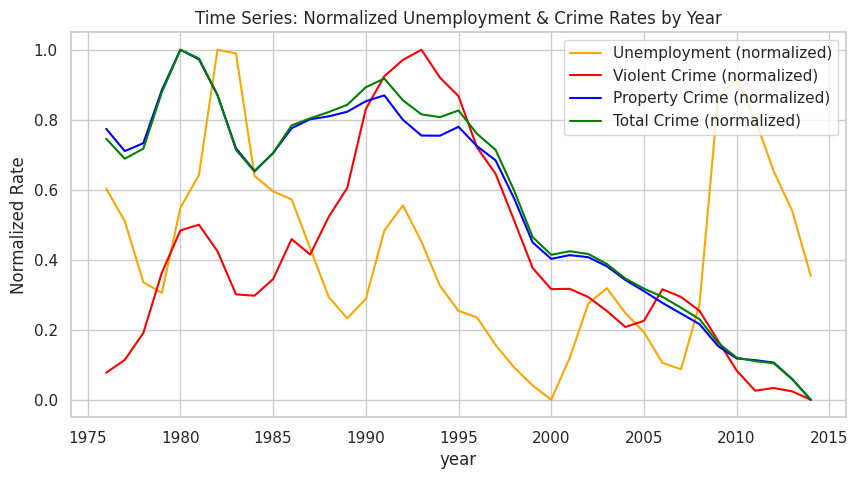

In [90]:
# 🔹 4. Time Series Plot by Year
yearly = df.groupby('year').agg({'unemployment': 'mean', 'violent_total': 'mean', 'property_total': 'mean', 'total_crime': 'mean'}).reset_index()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(yearly[['unemployment', 'violent_total', 'property_total', 'total_crime']])
yearly_scaled = pd.DataFrame(scaled, columns=['unemployment', 'violent_total', 'property_total', 'total_crime'])
yearly_scaled['year'] = yearly['year']

plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_scaled, x='year', y='unemployment', label='Unemployment (normalized)', color='orange')
sns.lineplot(data=yearly_scaled, x='year', y='violent_total', label='Violent Crime (normalized)', color='red')
sns.lineplot(data=yearly_scaled, x='year', y='property_total', label='Property Crime (normalized)', color='blue')
sns.lineplot(data=yearly_scaled, x='year', y='total_crime', label='Total Crime (normalized)', color='green')
plt.title('Time Series: Normalized Unemployment & Crime Rates by Year')
plt.ylabel('Normalized Rate')
plt.grid(True)
plt.legend()
plt.show()

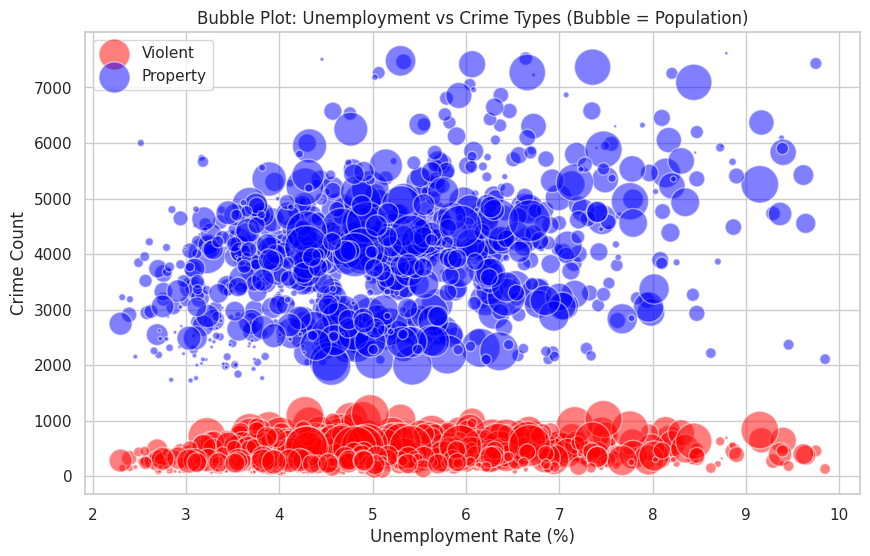

In [91]:
# 🔹 5. Bubble Plot: Add Population Dimension
plt.figure(figsize=(10, 6))
sizes = (df_filtered['population'] - df_filtered['population'].min()) / (df_filtered['population'].max() - df_filtered['population'].min()) * 1000
plt.scatter(df_filtered['unemployment'], df_filtered['violent_total'], s=sizes, alpha=0.5, c='red', edgecolors='w', label='Violent')
plt.scatter(df_filtered['unemployment'], df_filtered['property_total'], s=sizes, alpha=0.5, c='blue', edgecolors='w', label='Property')
plt.title('Bubble Plot: Unemployment vs Crime Types (Bubble = Population)')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Crime Count')
plt.legend()
plt.grid(True)
plt.show()

For Violent Crime:
H₀ (null): There is no difference in violent crime rates between high and low unemployment groups.

H₁ (alt): There is a significant difference in violent crime rates between the groups.

For Property Crime:
H₀ (null): There is no difference in property crime rates between high and low unemployment groups.

H₁ (alt): There is a significant difference in property crime rates between the groups.

We will make the follwing tests to reject both Null Hypotheses


## 🧪 6. Hypothesis Test

In [98]:
median_unemp = df_filtered['unemployment'].median()
high = df_filtered[df_filtered['unemployment'] > median_unemp]
low = df_filtered[df_filtered['unemployment'] <= median_unemp]

# Perform Z-tests
z_stat_v, p_val_z_v = ztest(high['violent_total'], low['violent_total'])
z_stat_p, p_val_z_p = ztest(high['property_total'], low['property_total'])
z_stat_c, p_val_z_c = ztest(high['total_crime'], low['total_crime'])

print(f"Violent Crime Z-test: z = {z_stat_v:.4f}, p-value = {p_val_z_v:.11f}")
print(f"Property Crime Z-test: z = {z_stat_p:.4f}, p-value = {p_val_z_p:.23f}")
print(f"Crime Rate Z-test: z = {z_stat_c:.4f}, p-value = {p_val_z_c:.23f}")

print("\n")
alpha = 0.05

# Interpret the Violent Crime Z-test
print("Violent Crime Z-test Interpretation:")
if p_val_z_v < alpha:
    print(f"The p-value ({p_val_z_v:.11f}) is less than the significance level ({alpha}).")
    print("We reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in violent crime rates between high and low unemployment groups.")
else:
    print(f"The p-value ({p_val_z_v:.11f}) is greater than or equal to the significance level ({alpha}).")
    print("We fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant difference in violent crime rates between high and low unemployment groups.")

print("-" * 30) # Separator for readability

# Interpret the Property Crime Z-test
print("Property Crime Z-test Interpretation:")
if p_val_z_p < alpha:
    print(f"The p-value ({p_val_z_p:.23f}) is less than the significance level ({alpha}).")
    print("We reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in property crime rates between high and low unemployment groups.")
else:
    print(f"The p-value ({p_val_z_p:.23f}) is greater than or equal to the significance level ({alpha}).")
    print("We fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant difference in property crime rates between high and low unemployment groups.")

print("-" * 30)

# Interpret the Total Crime Z-test
print("Total Crime Rate Z-test Interpretation:")
if p_val_z_c < alpha:
    print(f"The p-value ({p_val_z_c:.23f}) is less than the significance level ({alpha}).")
    print("We reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in total crime rates between high and low unemployment groups.")
else:
    print(f"The p-value ({p_val_z_c:.23f}) is greater than or equal to the significance level ({alpha}).")
    print("We fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant difference in total crime rates between high and low unemployment groups.")

Violent Crime Z-test: z = 4.0684, p-value = 0.00004734715
Property Crime Z-test: z = 9.1072, p-value = 0.00000000000000000008450
Crime Rate Z-test: z = 8.9179, p-value = 0.00000000000000000047517


Violent Crime Z-test Interpretation:
The p-value (0.00004734715) is less than the significance level (0.05).
We reject the null hypothesis.
Conclusion: There is a statistically significant difference in violent crime rates between high and low unemployment groups.
------------------------------
Property Crime Z-test Interpretation:
The p-value (0.00000000000000000008450) is less than the significance level (0.05).
We reject the null hypothesis.
Conclusion: There is a statistically significant difference in property crime rates between high and low unemployment groups.
------------------------------
Total Crime Rate Z-test Interpretation:
The p-value (0.00000000000000000047517) is less than the significance level (0.05).
We reject the null hypothesis.
Conclusion: There is a statistically sign

In [93]:
# Calculate Pearson correlation coefficients
r_v, p_v = stats.pearsonr(df_filtered['unemployment'], df_filtered['violent_total'])
r_p, p_p = stats.pearsonr(df_filtered['unemployment'], df_filtered['property_total'])
r_c, p_c = stats.pearsonr(df_filtered['unemployment'], df_filtered['total_crime'])

def correlation_strength(r):
    r_abs = abs(r)
    if 0 <= r_abs <= 0.2:
        return "Very weak"
    elif 0.2 < r_abs <= 0.4:
        return "Weak"
    elif 0.4 < r_abs <= 0.6:
        return "Moderate"
    elif 0.6 < r_abs <= 0.8:
        return "Strong"
    elif 0.8 < r_abs <= 1.0:
        return "Very strong"

# Print results with correlation strength
print("\nPearson Correlation Results:")
print(f"Violent Crime: r = {r_v:.4f}, p = {p_v:.14f}, How strong is the correlation? Strength: {correlation_strength(r_v)}")
print(f"Property Crime: r = {r_p:.4f}, p = {p_p:.32f}, How strong is the correlation? Strength: {correlation_strength(r_p)}")
print(f"Crime Rate: r = {r_c:.4f}, p = {p_c:.32f}, How strong is the correlation? Strength: {correlation_strength(r_c)}")


Pearson Correlation Results:
Violent Crime: r = 0.1842, p = 0.00000001570639, How strong is the correlation? Strength: Very weak
Property Crime: r = 0.3531, p = 0.00000000000000000000000000011604, How strong is the correlation? Strength: Weak
Crime Rate: r = 0.3496, p = 0.00000000000000000000000000042031, How strong is the correlation? Strength: Weak


7. Linear Regression Analysis

In [94]:
# --- Violent Crime Regression ---
X_violent = sm.add_constant(df_filtered['unemployment'])
y_violent = df_filtered['violent_total']
model_violent = sm.OLS(y_violent, X_violent).fit()

# --- Property Crime Regression ---
X_property = sm.add_constant(df_filtered['unemployment'])
y_property = df_filtered['property_total']
model_property = sm.OLS(y_property, X_property).fit()

# --- Total Crime rate Regression ---
X_total = sm.add_constant(df_filtered['unemployment'])
y_total = df_filtered['total_crime']
model_total = sm.OLS(y_total, X_total).fit()


def interpret_model(model, crime_type):
    intercept = model.params['const']
    coef = model.params['unemployment']
    p_val = model.pvalues['unemployment']
    r_squared = model.rsquared

    significance = "< 0.001" if p_val < 0.001 else round(p_val, 4)
    reject_null = p_val < 0.05

    print(f"### {crime_type} vs Unemployment")
    print(f"- Intercept (const): {intercept:.2f}")
    print(f"- Unemployment coefficient: {coef:.2f}")
    print(f"- p-value: {significance} ✅ statistically significant" if reject_null else f"- p-value: {significance} ❌ not significant")
    print(f"- R² = {r_squared:.3f} → Unemployment explains {r_squared*100:.1f}% of the variance in {crime_type.lower()} rates")
    print(f"- Interpretation: For each 1% increase in unemployment, {crime_type.lower()} increases by about {coef:.1f} incidents per 100,000 people")
    print(f"- Hypothesis test: We {'reject' if reject_null else 'fail to reject'} the null hypothesis.\n")

interpret_model(model_violent, "Violent Crime")
interpret_model(model_property, "Property Crime")
interpret_model(model_total, "Total Crime")

### Violent Crime vs Unemployment
- Intercept (const): 287.72
- Unemployment coefficient: 25.10
- p-value: < 0.001 ✅ statistically significant
- R² = 0.034 → Unemployment explains 3.4% of the variance in violent crime rates
- Interpretation: For each 1% increase in unemployment, violent crime increases by about 25.1 incidents per 100,000 people
- Hypothesis test: We reject the null hypothesis.

### Property Crime vs Unemployment
- Intercept (const): 2510.96
- Unemployment coefficient: 276.23
- p-value: < 0.001 ✅ statistically significant
- R² = 0.125 → Unemployment explains 12.5% of the variance in property crime rates
- Interpretation: For each 1% increase in unemployment, property crime increases by about 276.2 incidents per 100,000 people
- Hypothesis test: We reject the null hypothesis.

### Total Crime vs Unemployment
- Intercept (const): 2798.68
- Unemployment coefficient: 301.34
- p-value: < 0.001 ✅ statistically significant
- R² = 0.122 → Unemployment explains 12.2% of the vari

## 📏 7. Confidence Interval

In [96]:
conf_v = stats.t.interval(0.95, len(df_filtered)-1, loc=df_filtered['violent_total'].mean(), scale=stats.sem(df_filtered['violent_total']))
conf_p = stats.t.interval(0.95, len(df_filtered)-1, loc=df_filtered['property_total'].mean(), scale=stats.sem(df_filtered['property_total']))
conf_c = stats.t.interval(0.95, len(df_filtered)-1, loc=df_filtered['total_crime'].mean(), scale=stats.sem(df_filtered['total_crime']))
print(f"\n95% CI for Violent Crime mean is between: ({conf_v[0]:.4f}, {conf_v[1]:.4f})")
print(f"95% CI for Property Crime mean is between: ({conf_p[0]:.4f}, {conf_p[1]:.4f})")
print(f"95% CI for Crime Rate mean is between: ({conf_c[0]:.4f}, {conf_c[1]:.4f})")


95% CI for Violent Crime mean is between: (404.1363, 429.7735)
95% CI for Property Crime mean is between: (3859.4009, 4006.5282)
95% CI for Crime Rate mean is between: (4268.8812, 4430.9577)


## ✅ 8. Conclusion

In [97]:
print("\nConclusion:")
if p_v < 0.05 and p_p < 0.05:
  print("There is a significant relationship between unemployment and (violent & property) crime.")

else:
  if p_v < 0.05:
      print("There is a significant relationship between unemployment and violent crime.")
  else:
      print("No significant relationship between unemployment and violent crime.")

  if p_p < 0.05:
      print("There is a significant relationship between unemployment and property crime.")
  else:
      print("No significant relationship between unemployment and property crime.")




Conclusion:
There is a significant relationship between unemployment and (violent & property) crime.
